# LSTM  + ElMO

En esta, rehacemos todo lo de ElMO pero usando nuestra nueva clase: ElMOModel

In [1]:
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/test_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Tengo que hacer dos cosas:

- Primero, convertir los tweets a secuencias de texto
- Luego, paddear las secuencias a cierta longitud (Keras necesita esto para poder paralelizar cálculo)

In [2]:
from hate.nn.preprocessing import Tokenizer

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
    "stem": False
}

tokenizer = Tokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

tokens_train = [tokenizer.tokenize(tweet) for tweet in df_train["text"].values]
tokens_dev = [tokenizer.tokenize(tweet) for tweet in df_dev["text"].values]
tokens_test = [tokenizer.tokenize(tweet) for tweet in df_test["text"].values]

Using TensorFlow backend.


Veamos las distribuciones de las longitudes de tokens

Media de longitud: train 22.91 dev 23.33 test 23.33


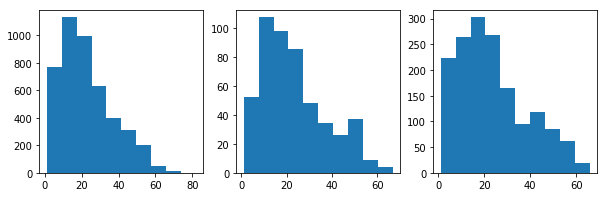

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,3)

train_lens = np.array([len(t) for t in tokens_train]) 
dev_lens = np.array([len(t) for t in tokens_dev])
test_lens = np.array([len(t) for t in tokens_test])

plt.subplot(1, 3, 1)

plt.hist(train_lens)

plt.subplot(1, 3, 2)
plt.hist(dev_lens)

plt.subplot(1, 3, 3)
plt.hist(test_lens)

print("Media de longitud: train {:.2f} dev {:.2f} test {:.2f}".format(train_lens.mean(), dev_lens.mean(), test_lens.mean()))


In [4]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

2019-01-20 16:29:06,430 INFO: char embedding size: 2637
2019-01-20 16:29:07,386 INFO: word embedding size: 185214
2019-01-20 16:29:16,407 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(185214, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(2637, 50, padding_idx=2634)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

Carguemos embeddings

In [5]:
from hate.nn import ElmoModel
from keras.optimizers import Adam
from keras.layers import CuDNNLSTM, CuDNNGRU

embedding_dim = 1024

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01
}

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
    "stem": False
}

max_len = 60

X_train, y_train = df_train["text"], df_train["HS"]
X_dev, y_dev = df_dev["text"], df_dev["HS"]

model = ElmoModel(
    max_len=60, embedder=e, tokenize_args=tokenize_args,
    recursive_class=CuDNNLSTM,
)

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Elmo_Input (InputLayer)      (None, 60, 1024)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               1181696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_elmo (Dense)           (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 1,214,721
Trainable params: 1,214,721
Non-trainable params: 0
_________________________________________________________________


In [6]:
from keras.callbacks import ModelCheckpoint, BaseLogger

checkpointer = ModelCheckpoint('/tmp/elmo_15.h5', 
                               save_best_only=True, monitor='val_acc', verbose=1)
logger = BaseLogger(['accuracy'])

history_callback = model.fit(X_train, y_train, callbacks=[logger, checkpointer], 
                             validation_data=(X_dev, y_dev), epochs=40, batch_size=32)

2019-01-20 16:29:35,009 INFO: 71 batches, avg len: 62.0
2019-01-20 16:29:39,928 INFO: Finished 1000 sentences.
2019-01-20 16:29:43,723 INFO: Finished 2000 sentences.
2019-01-20 16:29:47,318 INFO: Finished 3000 sentences.
2019-01-20 16:29:51,115 INFO: Finished 4000 sentences.
2019-01-20 16:29:54,826 INFO: 8 batches, avg len: 62.0


2019-01-20 16:29:57,067 WARNING: Variable *= will be deprecated. Use `var.assign(var * other)` if you want assignment to the variable value or `x = x * y` if you want a new python Tensor object.


Train on 4500 samples, validate on 500 samples
Epoch 1/40
4500/4500 [==============================] - 5s 1ms/step - loss: 0.7059 - acc: 0.5662 - val_loss: 0.6664 - val_acc: 0.6180

Epoch 00001: val_acc improved from -inf to 0.61800, saving model to /tmp/elmo_15.h5
Epoch 2/40
4500/4500 [==============================] - 3s 576us/step - loss: 0.6642 - acc: 0.6051 - val_loss: 0.6534 - val_acc: 0.6460

Epoch 00002: val_acc improved from 0.61800 to 0.64600, saving model to /tmp/elmo_15.h5
Epoch 3/40
4500/4500 [==============================] - 3s 572us/step - loss: 0.6359 - acc: 0.6444 - val_loss: 0.6267 - val_acc: 0.6620

Epoch 00003: val_acc improved from 0.64600 to 0.66200, saving model to /tmp/elmo_15.h5
Epoch 4/40
4500/4500 [==============================] - 3s 574us/step - loss: 0.6197 - acc: 0.6629 - val_loss: 0.6067 - val_acc: 0.6700

Epoch 00004: val_acc improved from 0.66200 to 0.67000, saving model to /tmp/elmo_15.h5
Epoch 5/40
4500/4500 [==============================] - 3s 568

In [7]:
accuracies = history_callback.history['val_acc']

In [8]:
max(accuracies)

0.8060000004768372

In [9]:
from hate.utils import print_evaluation

model.load_weights(checkpointer.filepath)

print_evaluation(model, X_dev, y_dev)

2019-01-20 16:31:51,768 INFO: 8 batches, avg len: 62.0


500/500 [==============================] - 0s 274us/step


2019-01-20 16:31:55,245 INFO: 8 batches, avg len: 62.0


Loss        : 0.4513
Accuracy    : 0.8060
Precision   : 0.7990
Recall      : 0.7523
F1          : 0.7749


## Submission

In [17]:
df_test["preds"] = (model.predict(df_test["text"]) >= 0.5).astype(int)
df_dev["preds"] = (model.predict(df_dev["text"]) >= 0.5).astype(int)

2019-01-20 16:34:25,682 INFO: 25 batches, avg len: 62.0
2019-01-20 16:34:30,822 INFO: Finished 1000 sentences.
2019-01-20 16:34:35,083 INFO: 8 batches, avg len: 62.0


In [ ]:

dev_submission = "../../../submissions/dev/15_elmo.tsv" 

df_test.to_csv("../../../submissions/15_elmo.tsv", columns=["id", "preds"], 
              sep='\t', quoting=csv.QUOTE_NONE, header=False)


In [40]:
i, r = list(df_test.iterrows())[0]

In [48]:

with open('es_a.tsv', 'w') as f:
    for i, row in df_test.iterrows():
        f.write('{}\t{}\n'.format(i, row["preds"]))


In [49]:
!cp es_a.tsv ../../../submissions/15_elmo.tsv

In [50]:
import zipfile

with zipfile.ZipFile("es_a.tsv.zip", 'w') as f:
    f.write('es_a.tsv')
